In [38]:
from gensim.test.utils import common_texts  # some example sentences
from gensim.models import FastText
from gensim.corpora.csvcorpus import CsvCorpus
from gensim.models.word2vec import LineSentence
import pandas as pd
from gensim import corpora
from pprint import pprint
from gensim.models.fasttext import load_facebook_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [2]:
test_model = FastText(size=4, window=3, min_count=1) 
test_model.build_vocab(sentences=common_texts)
test_model.train(sentences=common_texts, total_examples=len(common_texts), epochs=10)  # train
test_model.wv["computer"]

NameError: name 'model' is not defined

In [5]:
dataset = pd.read_csv("../cleaned/test_clean.csv", delimiter=",")["t"].tolist()
sentences = [sentence.split() for sentence in dataset]
words = [word.lower() for sentence in sentences for word in sentence]
#print(sentences)

#print(words)
# build a dictionary, must be a list in a list !! creating dictionary makes some words uppercase
dictionary = corpora.Dictionary([words])
#for k, v in word_dictionary.token2id.items():
#    print(f'{k:{15}} {v:{10}}')
# get id for word in dictionary
#    print(dictionary.token2id["dragons"])
# how often does the token with this id is in the documents
#    print(dictionary.cfs[11])
# add more documents to the dictionary
#    dictionary.add_documents([["cat", "say", "meow"], ["dog"]])
# make bag-of-words-dictionary: tuple (id_of_word, number_of_occurence_of_word_in_document)
#    bow_corpus = [dictionary.doc2bow(word, allow_update=True) for word in [words]]
#    print(bow_corpus)

# build model over sentences (size=dimension of word vectors)
test_model_2 = FastText(size=4, window=3, min_count=1)
test_model_2.build_vocab(sentences)  # scan over corpus to build the vocabulary
test_model_2.train(sentences=sentences, total_examples=len(sentences), total_words=test_model_2.corpus_total_words, epochs=5)

In [8]:
# check if word is in vocab
in_vocab_word = "resentment"
out_vocab_word = "computer"
#print(in_vocab_word in model3.wv.vocab)
#print(out_vocab_word in model3.wv.vocab)
# get word vectors
#print(model3.wv[in_vocab_word])
#print(model3.wv[out_vocab_word])

# find similar words, 
similarities = test_model_2.wv.most_similar(positive=['destroyer'], negative=['resentment']) # sttt most_similar get auch most_similar_cosmul
#print(similarities) # first entry in list is the most similar 
# see what word in a list doesnt fit with the others
not_matching = test_model_2.wv.doesnt_match(["human", "computer", "interface", "tree"])
#print(not_matching)
# get similarity score, from 0 to 1
sim_score = test_model_2.wv.similarity('computer', 'human')
#print(sim_score)

# man kann hiermit auch vektoren für ganze sätze generieren
#print(model3.wv["hello"])
#print(model3.wv["hello my friend"])

/home/marcel/.local/lib/python3.6/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


In [10]:
dataset = pd.read_csv("../cleaned/tweet_stems.csv", delimiter=",").astype(str)
sentences2 = dataset.values.tolist()

# remove placeholder
for index, sentence in enumerate(sentences2): 
        sentences2[index] = list(filter(("__").__ne__, sentence))

# build model over sentences (size=dimension of word vectors)
log_model = FastText(size=8, window=3, min_count=1)
log_model.build_vocab(sentences2)  # scan over corpus to build the vocabulary
log_model.train(sentences=sentences2, total_examples=len(sentences), total_words=log_model.corpus_total_words, epochs=5)

In [40]:
def make_data(dataset_name):
    affect_mapping = {"happiness": 0, "sadness": 1, "anger": 2, "fear": 3, "disgust": 4}
    sentences = pd.read_csv("../cleaned/" + dataset_name + "_stems.csv", delimiter=",").values.tolist()
    targets = pd.read_csv("../cleaned/" + dataset_name + "_clean.csv", delimiter=",")["a"].tolist()  
    # remove placeholder, map affect to number
    for index, sample in enumerate(sentences): 
            sentences[index] = list(filter(("__").__ne__, sample))
    targets = [affect_mapping[affect] for affect in targets]
    # make one-string-sentences
    inputs = [" ".join(sentence) for sentence in sentences]
    
    # build model over sentences (size=dimension of word vectors)
    model = FastText(size=16, window=3, min_count=1)
    model.build_vocab(inputs)  
    model.train(sentences=inputs, total_examples=len(inputs), total_words=model.corpus_total_words, epochs=5)
    # convert sentences to vectors
    inputs = [model.wv[sample] for sample in inputs]
    
    # split data and return
    train_x, test_x, train_y, test_y = train_test_split(inputs, targets, test_size=0.2)
    return train_x, test_x, train_y, test_y    
    
train_x, test_x, train_y, test_y = make_data("test")

trees: 50	score:  1.0
...feature importance [0.05605698 0.0451601  0.08297177 0.06025502 0.04350893 0.0676476
 0.02889393 0.07304336 0.07743617 0.10955989 0.03650654 0.1159834
 0.05886038 0.05300971 0.02283425 0.06827197]
weighted f1_score:  0.2571428571428571


/home/marcel/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


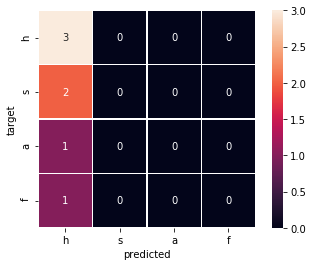

In [39]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(train_x, train_y)
print("trees: 50\tscore: ", rf.score(train_x, train_y))
print("...feature importance", rf.feature_importances_)

pred_y = rf.predict(test_x)
print("weighted f1_score: ", f1_score(test_y, pred_y, average="weighted"))
cm = confusion_matrix(test_y, pred_y)
sn.heatmap(cm, fmt="d", linewidth=0.5, annot=True, square=True, xticklabels=["h", "s", "a", "f"], yticklabels=["h", "s", "a", "f"])
plt.xlabel("predicted")
plt.ylabel("target")
plt.show()